# CPSC 533R Visual AI - Assignment 1

In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [11]:
# Use standard FashionMNIST dataset
def gray_to_color(x):
    return x.repeat(3, 1, 1)

#train_set = torchvision.datasets.FashionMNIST(
train_set = torchvision.datasets.MNIST(
    root = './DatasetMNIST',
    train = True,
    download = False,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)
loader = torch.utils.data.DataLoader(train_set, batch_size = 64, num_workers=0)

In [3]:
network = torchvision.models.resnet18(num_classes=10)

In [4]:
losses = []
iterator = iter(loader)
network = network.to('cuda')
optimizer = optim.SGD(network.parameters(), lr=0.001)
for i in range(200): #range(len(loader)):
    batch = next(iterator)
    preds = network(batch[0].cuda())
    loss = nn.functional.cross_entropy(preds, batch[1].cuda())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if i%10==0:
        print(i,losses[-1])

0 2.529468059539795
10 2.2252535820007324
20 2.101091146469116
30 1.8177764415740967
40 1.6227684020996094
50 1.3932350873947144
60 1.2563787698745728
70 1.2264128923416138
80 1.2030493021011353
90 1.1565988063812256
100 0.8635305166244507
110 0.9128180146217346
120 0.8375928997993469
130 0.9328532218933105
140 0.6182001233100891
150 0.8579568266868591
160 0.8275616765022278
170 0.6090441942214966
180 0.6547042727470398
190 0.5676907300949097


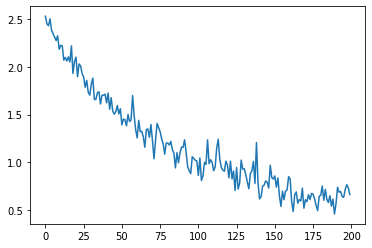

In [5]:
plt.plot(losses)

## Assignment 1-3: Data handling

In [2]:
### Task 1:

In [33]:
class wrappedMinistDataset:
    
    def __init__(self, root, train, download, transform):
        self.mnistDataset = torchvision.datasets.MNIST(
                                root = root,
                                train = train,
                                download = download,
                                transform = transform
                            )
        
    def __getitem__(self, index):
        img, label = self.mnistDataset.__getitem__(index)
        return {"img": img, "class": label}
    
    def __len__(self):
        return self.mnistDataset.__len__()

class modelRes18(nn.Module):
    def __init__(self, num_classes=10):
        super(modelRes18, self).__init__()
        self.backbone = torchvision.models.resnet18(num_classes=num_classes)
    
    def forward(self, input_dict):
        tensor = input_dict["img"].cuda()
        preds = self.backbone(tensor)
        return {"class": preds}

def train_process(model, train_set):
    loader = torch.utils.data.DataLoader(train_set, batch_size = 64, num_workers=0)
    iterator = iter(loader)
    losses = []
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    for i in range(200): #range(len(loader)):
        batch = next(iterator)
        preds = model(batch)
        loss = nn.functional.cross_entropy(preds["class"], batch["class"].cuda())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if i%10==0:
            print(i,losses[-1])
    plt.plot(losses)

0 2.488495111465454
10 2.2519888877868652
20 2.025195598602295
30 1.6212637424468994
40 1.6183890104293823
50 1.3491549491882324
60 1.1200385093688965
70 1.1216919422149658
80 1.2122421264648438
90 1.0272216796875
100 0.8914848566055298
110 0.8383792042732239
120 0.8813555240631104
130 0.7524157166481018
140 0.605955958366394
150 0.8334943056106567
160 0.8104377388954163
170 0.5289085507392883
180 0.6766757965087891
190 0.5963340401649475


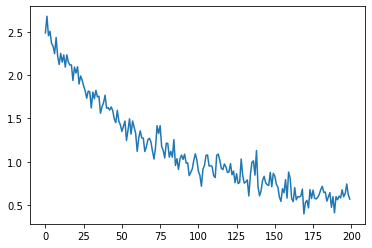

In [34]:
train_set = wrappedMinistDataset(
    root = './DatasetMNIST',
    train = True,
    download = False ,
    transform = transforms.Compose([
        transforms.ToTensor(),
        gray_to_color,
    ])
)
model = modelRes18(num_classes=10)
model = model.to("cuda")
train_process(model, train_set)